# Visualize sponsorships of mayors in metropolitan France for next presidential election (2022)

In [1]:
%load_ext lab_black

In [2]:
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#### Load sponsorship data from French open data portal here:
#### https://www.data.gouv.fr/fr/datasets/parrainages-des-candidats-a-lelection-presidentielle-francaise-de-2022/

In [3]:
parrainages_url = (
    "https://www.data.gouv.fr/fr/datasets/r/bb9b4c36-8baa-4c93-b7e3-da987c5b599a"
)

In [4]:
p_df = pd.read_csv(parrainages_url, sep=";")
p_df.head(2)

,Civilité,Nom,Prénom,Mandat,Circonscription,Département,Candidat,Date de publication
0,M.,CORDIVAL,Gilles,Maire,Mont-Saint-Père,Aisne,ARTHAUD Nathalie,01/02/2022
1,Mme,VALLIET,Odile,Maire,Crupilly,Aisne,ARTHAUD Nathalie,01/02/2022


In [5]:
print(f"Nb of sponsorships: {p_df.shape[0]}")

Nb of sponsorships: 5086


In [6]:
m_df = p_df.query('Mandat == "Maire"')
print(f"Nb of sponsorships by mayors: {m_df.shape[0]}")

Nb of sponsorships by mayors: 3270


#### Top sponsorships

In [7]:
m_df["Candidat"].value_counts().nlargest(10)

MACRON Emmanuel          505
PÉCRESSE Valérie         480
ARTHAUD Nathalie         340
LASSALLE Jean            310
HIDALGO Anne             291
DUPONT-AIGNAN Nicolas    225
ROUSSEL Fabien           203
MÉLENCHON Jean-Luc       175
ZEMMOUR Éric             139
ASSELINEAU François      134
Name: Candidat, dtype: int64

In [8]:
above_ten = list(
    m_df["Candidat"].value_counts()[m_df["Candidat"].value_counts() > 10].index
)
print(f"{len(above_ten)} candidates with more than 10 (mayor) sponsorships")

18 candidates with more than 10 (mayor) sponsorships


In [9]:
m_f_df = m_df.query("Candidat in @above_ten")
m_f_df.shape

(3237, 8)

In [10]:
len(list(m_f_df["Circonscription"].unique()))

3212

#### Load info on department from the French open data portal here:
#### https://www.data.gouv.fr/fr/datasets/departements-de-france/

In [11]:
dep_url = "https://www.data.gouv.fr/fr/datasets/r/70cef74f-70b1-495a-8500-c089229c0254"

In [12]:
dep_df = pd.read_csv(dep_url, sep=",")
nom_to_code = dict(zip(dep_df.nom_departement, dep_df.code_departement))
print(len(nom_to_code))

101


#### Load city data from OSM open data here:
#### https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/

In [13]:
osm_fp = "communes-20220101-shp/communes-20220101.shp"

In [14]:
com_gdf = gpd.read_file(osm_fp)
com_gdf.head(2)

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.20010 42.39013, 9.20014 42.39014, ..."


In [15]:
#### Metropolitan France
outre_deps = ["971", "972", "973", "974", "976"]
metro_com_gdf = com_gdf.query("insee.str.slice(0,3) not in @outre_deps")

#### Patch difference of names in files

In [16]:
# Problems of names
[
    l
    for l in list(m_f_df["Circonscription"].unique())
    if l not in list(com_gdf["nom"].unique())
]

['Les Hauts-Talican', 'Le Haut Soultzbach']

In [17]:
# Patch
mfp_df = m_f_df.copy()
mfp_df.loc[
    mfp_df.Circonscription == "Les Hauts-Talican", "Circonscription"
] = "Les Hauts Talican"
mfp_df.loc[
    mfp_df.Circonscription == "Le Haut Soultzbach", "Circonscription"
] = "Le Haut-Soultzbach"
print(
    len(
        [
            l
            for l in list(mfp_df["Circonscription"].unique())
            if l not in list(com_gdf["nom"].unique())
        ]
    )
)

0


#### Get sponsor from code of department and name of city (several French cities have the same name...)

In [18]:
code_city_sponsor = defaultdict(lambda: defaultdict(str))
for index, row in mfp_df.iterrows():
    code = nom_to_code[row["Département"]]
    code_city_sponsor[code][row["Circonscription"]] = row["Candidat"]
# test
code_city_sponsor["31"]["Antignac"]

'LASSALLE Jean'

In [19]:
gdf = metro_com_gdf.copy()
gdf["candidat"] = gdf.apply(
    lambda x: code_city_sponsor[str(x.insee)[:2]][x.nom], axis=1
)

#### Plot cities with color of selected candidate (by mayor)

In [20]:
candidats = {
    "MACRON Emmanuel": "darkorange",
    "PÉCRESSE Valérie": "blue",
    "ARTHAUD Nathalie": "firebrick",
    "LASSALLE Jean": "gold",
    "HIDALGO Anne": "fuchsia",
    "DUPONT-AIGNAN Nicolas": "cyan",
    "ROUSSEL Fabien": "red",
    "MÉLENCHON Jean-Luc": "darkviolet",
    "ZEMMOUR Éric": "black",
    "ASSELINEAU François": "darkcyan",
    "POUTOU Philippe": "crimson",
    "JADOT Yannick": "green",
    "KAZIB Anasse": "indianred",
    "THOUY Hélène": "olive",
    "LE PEN Marine": "darkblue",
    "KUZMANOVIC Georges": "plum",
    "KOENIG Gaspard": "bisque",
    "TAUBIRA Christiane": "violet",
}

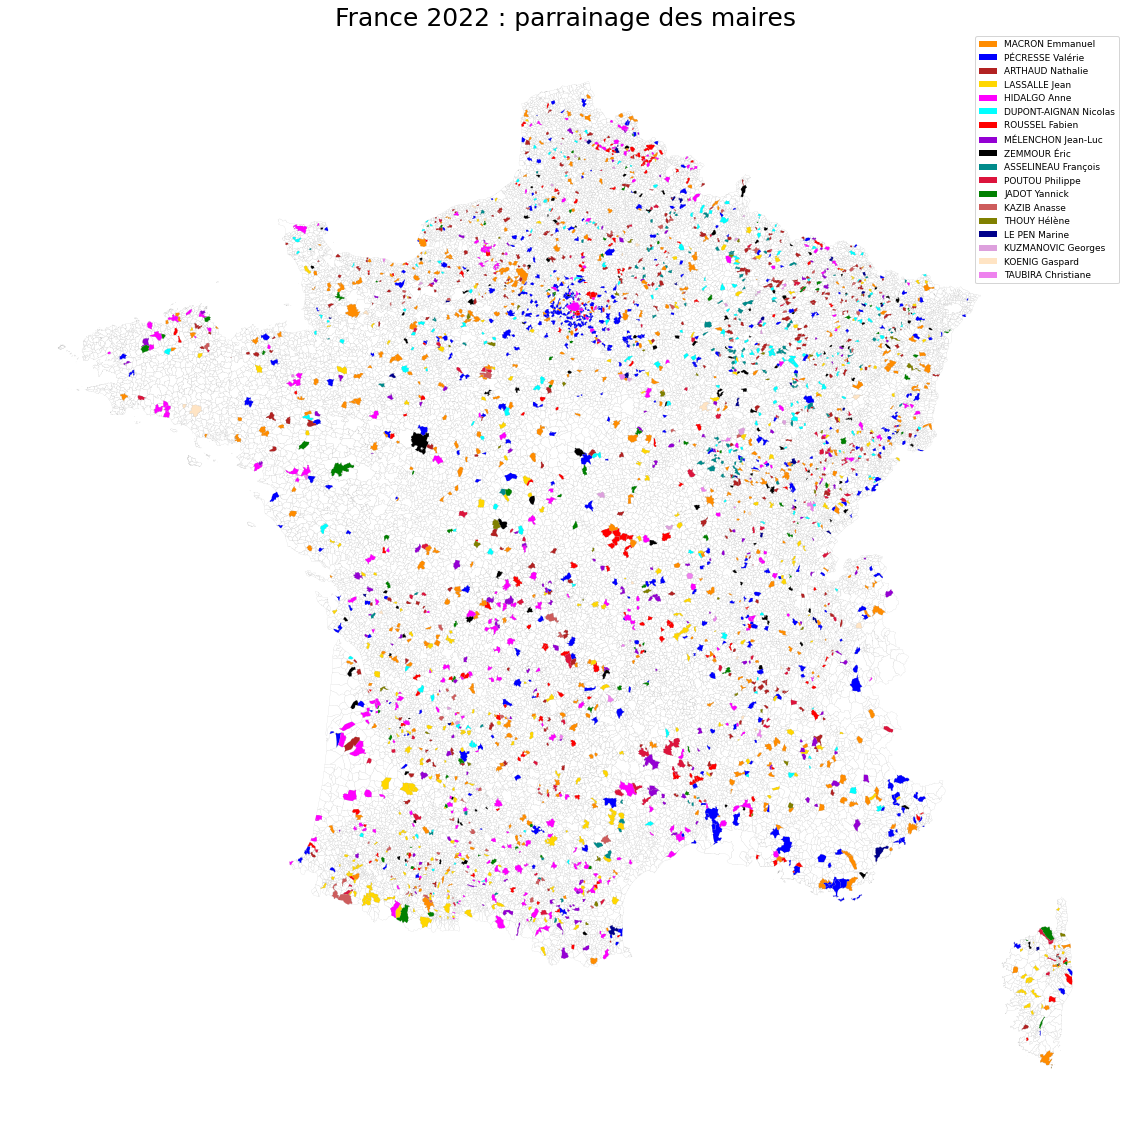

In [21]:
f, ax = plt.subplots(figsize=(20, 20))
pmarks = []
gdf.query("candidat == ''").plot(
    ax=ax,
    color="white",
    edgecolor="gray",
    linewidth=0.07,
)
for candidate, color in candidats.items():
    gdf.query("candidat == @candidate").plot(
        ax=ax,
        color=color,
        categorical=True,
        legend=True,
        edgecolor="gray",
        linewidth=0.07,
    )
    pmarks.append(Patch(facecolor=color, label=candidate))

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles, *pmarks], loc="best", fontsize=9)
ax.set_title("France 2022 : parrainage des maires", fontsize=25)
ax.set_axis_off()
plt.savefig("france-sponsors.png", dpi=150, bbox_inches="tight")